In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

if "/home/coberndorm/Documents/Semestre_IX/Artificial_Intelligence" not in sys.path:
  sys.path.append("/home/coberndorm/Documents/Semestre_IX/Artificial_Intelligence/")

In [2]:
import MLP.preprocessing as dm
import MLP.plottingFunctions as pltf

Getting the Iris dataset

In [3]:
from sklearn.datasets import load_iris

iris= load_iris()
data = iris.data

# Normalize data
data = dm.normalize_min_max(data)

## Calculate Distances

### Euclidea

In [4]:
def euclidean(x:np.ndarray , y:np.ndarray, type = None) -> float:
    return np.sqrt(np.sum((x-y)**2))

In [5]:
def euclidean_distances(data:np.ndarray) -> np.ndarray:
    n = data.shape[0]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance = euclidean(data[i],data[j])
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

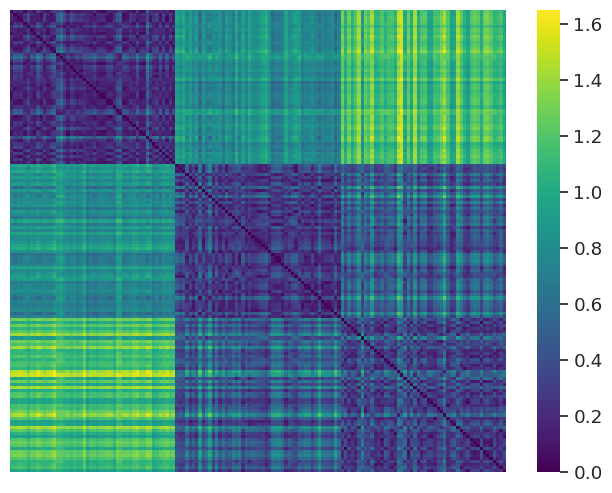

In [6]:
pltf.plot_heatmap(euclidean_distances(data))

### Mahalanobis

In [7]:
def mahalanobis(x:np.ndarray, y:np.ndarray, cov_inv:np.ndarray) -> float:
    delta = x-y
    return np.sqrt(np.dot(np.dot(delta.T, cov_inv), delta))

def inverse_covariance(data_X: np.ndarray, data_Y: np.ndarray, type = "cov") -> np.ndarray:
    
    assert type in ['cov', 'MAD'], "type must be 'cov' or 'MAD'"

    n = len(data_X)

    if type == 'cov':
        cov =  np.array([[np.sum((x - np.mean(x)) * (y - np.mean(y))) for x in data_X.T] for y in data_Y.T]) / (n-1)
        cov_inv = np.linalg.inv(cov)
        

    elif type == 'MAD':
        cov = np.array([[np.sum((x - np.median(x)) * (y - np.median(y))) for x in data_X] for y in data_Y]) / (n-1)
        cov_inv = np.linalg.inv(cov)
    
    return cov_inv

In [8]:
def mahalanobis_distances(data:np.ndarray, type='cov') -> np.ndarray:

    assert type in ['cov', 'MAD'], "type must be 'cov' or 'MAD'"

    n = data.shape[0]; m = data.shape[1]
    distances = np.zeros((n,n))

    if type == 'cov':
        cov =  np.array([[np.sum((x - np.mean(x)) * (y - np.mean(y))) for x in data.T] for y in data.T]) / (n-1)
        cov_inv = np.linalg.inv(cov)
        

    elif type == 'MAD':
        cov = np.array([[np.sum((x - np.median(x)) * (y - np.median(y))) for x in data] for y in data]) / (n-1)
        cov_inv = np.linalg.inv(cov)

    for i in range(n):
        for j in range(i,n):
            distance = mahalanobis(data[i],data[j], cov_inv)
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

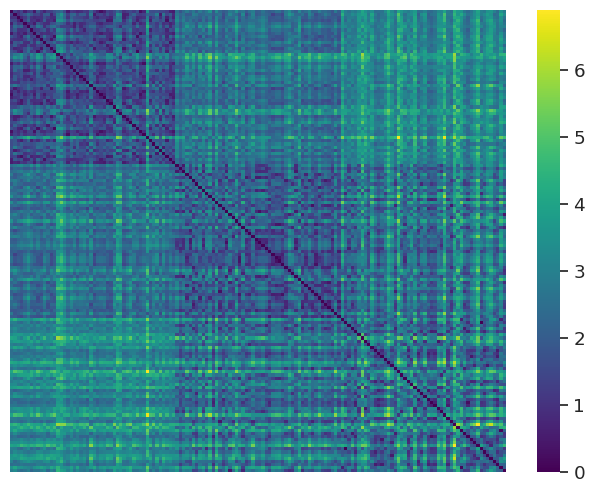

In [9]:
pltf.plot_heatmap(mahalanobis_distances(data, type='cov'))

### Manhattan

In [10]:
def manhattan(x:np.ndarray, y:np.ndarray, type = None) -> float:
    return np.sum(np.abs(x-y))

In [11]:
def manhattan_distances(data: np.ndarray) -> np.ndarray:
    n = data.shape[0]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance = manhattan(data[i],data[j])
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

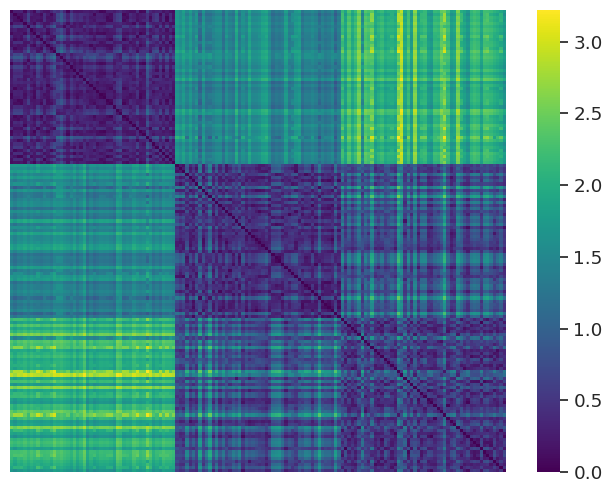

In [12]:
pltf.plot_heatmap(manhattan_distances(data))

### $\mathcal{l}_p$ 

In [13]:
def lp(x:np.ndarray, y:np.ndarray, p=1) -> float:

    assert (type(p) == int and p > 0) or p == "inf", "p must be a positive integer or \"inf\""

    if p == "inf":
        return np.max(np.abs(x-y))
    return np.sum(np.abs(x-y)**p)**(1/p)


In [14]:
def lp_distances(data:np.ndarray, p=1) -> np.ndarray:

    assert p > 0, "p must be greater than 0"
    assert type(p) == int or p == "inf", "p must be an integer or \"inf\""

    n = data.shape[0]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance = lp(data[i],data[j],p)
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

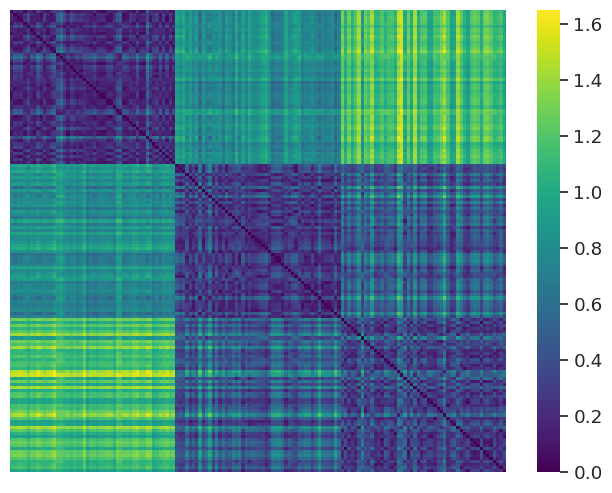

In [15]:
pltf.plot_heatmap(lp_distances(data, 2))

### Cosine semi-distance

In [16]:
def cosine(x:np.ndarray, y:np.ndarray, similarity = False) -> float:
    if similarity:
        return np.dot(x,y)/(np.sqrt(np.dot(x,x))*np.sqrt(np.dot(y,y)))
    else:
        return 1 - np.dot(x,y)/(np.sqrt(np.dot(x,x))*np.sqrt(np.dot(y,y)))

In [17]:
def cosine_distances(data:np.ndarray, similarity = False) -> np.ndarray:

    n = data.shape[0]
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance = cosine(data[i],data[j], similarity)
            distances[i,j] = distance
            distances[j,i] = distance

    return distances

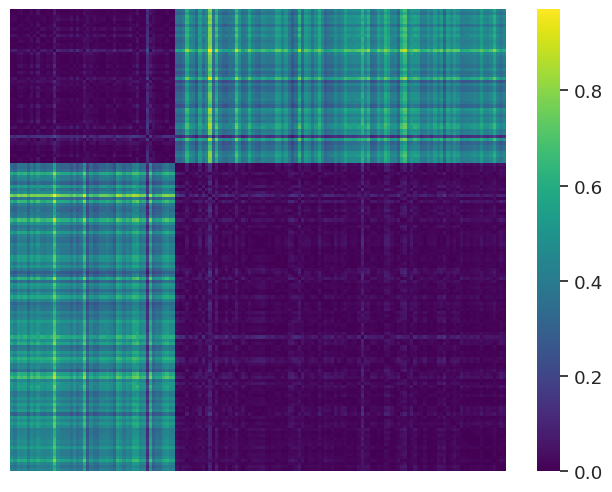

In [18]:
pltf.plot_heatmap(cosine_distances(data))

In [19]:
def distance_matrix(data_X: np.ndarray, data_Y = None, metric = euclidean, parameter = None) -> np.ndarray:

    assert metric != mahalanobis, "Function does not suppor mahal distances, call mahalanobis_distances"
    
    def distance_matrix_self(data: np.ndarray, metric) -> np.ndarray:
        n = data.shape[0]
        distances = np.zeros((n,n))
        for i in range(n):
            for j in range(i,n):
                distance = metric(data[i],data[j], parameter)
                distances[i,j] = distance
                distances[j,i] = distance

        return distances
    
    def distance_matrix_compare(data_X: np.ndarray, data_Y: np.ndarray, metric) -> np.ndarray:
        n = len(data_X); m = len(data_Y)
        distances = np.zeros((n,m))
        for i in range(n):
            for j in range(m):
                distance = metric(data_X[i],data_Y[j], parameter)
                distances[i,j] = distance

        return distances
        
    if data_Y == None:
        return distance_matrix_self(data_X, metric)
    else:
        return distance_matrix_compare(data_X, data_Y, metric)


# Mesh

In [20]:
def generate_grid_vertices(dim, partitions, a = 0, b = 1):
    """
    Generate all vertices in an n-dimensional grid with specified partitions.

    Parameters:
    - dim: The number of dimensions.
    - partitions: The distance between each vertex.
    - a: The lower bound of the grid.
    - b: The upper bound of the grid.

    Returns:
    - A list of tuples representing the coordinates of all grid vertices.
    """

    # Base case: 0-dimensional grid
    if dim == 0:
        return [()]
    # Recursive case: n-dimensional grid
    else:
        # Generate the vertices of an (n-1)-dimensional grid
        lower_dimension = generate_grid_vertices(dim - 1, partitions)
        vertices = []
        # Add vertices to the grid
        for coord in lower_dimension:
            # Add vertices in each dimension
            for offset in [i*((b-a)/(partitions-1)) for i in range(partitions)]:
                new_coord = coord + (offset,)
                vertices.append(new_coord)
        return vertices
    
grid = generate_grid_vertices(4,4)
grid = [list(x) for x in grid]

In [21]:
# Sorts the different points distances into boxes.
def boxes(dist: np.ndarray, div=4, step = 0.5, sort="boxes", symmetrical=True) -> dict:
    """
    Sorts the different points' distances into boxes.

    Parameters:
        - dist: The distance matrix.
        - div: The number of boxes.
        - sort: Whether to sort the points in the boxes (default is True).
        - symmetrical: Whether the distance matrix is symmetrical (default is True).

    Returns:
        - boxes: A dictionary with the boxes as keys and the points in the boxes as values (list of tuples (i, j, dist)).
    """

    assert sort in ["boxes", "distance"], "The 'sort' parameter must be either 'boxes' or 'distance'."

    n, m = dist.shape
    max_dist = np.max(dist)
    min_dist = np.min(dist)
    epsilon = 0.000000000001

    # Calculate the step size
    if sort == "boxes": 
        step = (max_dist - min_dist) / div + epsilon
    else: 
        step = step + epsilon

    # If the distance matrix is not square, it's not symmetrical
    symmetrical = False if n != m else symmetrical

    boxes = dict()
    for i in range(n):
        # Start from i+1 if the matrix is symmetrical to avoid duplicate entries
        start = i + 1 if symmetrical else 0
        for j in range(start, m):
            # Calculate the box for the current distance
            box = int(np.floor((dist[i, j] - min_dist) / (step)))
            
            # Add the point to the box
            if box not in boxes.keys():
                boxes[box] = [(i, j, dist[i, j])]
            else:
                boxes[box].append((i, j, dist[i, j]))

    boxes_keys = list(boxes.keys())

    # Reorganize the boxes into a dictionary with sequential keys to start from 0
    boxes = {i: boxes[boxes_keys[i]] for i in range(len(boxes_keys))}
    
    # Sort the points in each box based on the distance value
    return {k: sorted(v, key=lambda x: x[2]) for k, v in boxes.items()}

box_euclid = boxes(euclidean_distances(data), div=4, step = 0.05, sort="boxes", symmetrical=True)
len(box_euclid)

4

In [33]:
def sort_by_boxes(dist, div = 4):

    def new_dist_matrix(dist,new_axis_x, new_axis_y, n, m):
        new_dist_matrix = np.zeros((n,m))
        for i in range(n):
            for j in range(m):
                new_dist_matrix[i,j] = dist[new_axis_x[i], new_axis_y[j]]
        
        return new_dist_matrix

    box = boxes(dist, div, True)
    n,m = dist.shape
    new_axis_x = []; new_axis_y = []
    values_used_x = set(); values_used_y = set()
    amount_boxes = len(box)
    index_main_box_x = np.zeros((n,amount_boxes)); index_main_box_y = np.zeros((m,amount_boxes))

    for key,val in box.items():
        for point in val:
            index_main_box_x[point[0]][key] += 1
            index_main_box_y[point[1]][key] += 1

    index_main_box_x = [np.argmax(x) for x in index_main_box_x]; index_main_box_y = [np.argmax(y) for y in index_main_box_y]

    for key,val in box.items():
        for point in val:
            if point[0] not in values_used_x and int(key) == int(index_main_box_x[point[0]]):
                new_axis_x.append(point[0]); values_used_x.add(point[0])
            if point[1] not in values_used_y and int(key) == int(index_main_box_x[point[1]]):
                new_axis_y.append(point[1]); values_used_y.add(point[1])

            if len(values_used_x) == n and len(values_used_y) == m:
                return new_dist_matrix(dist, new_axis_x, new_axis_y,n,m)
            


dist = distance_matrix(data, metric=euclidean)
new_dist_matrix = sort_by_boxes(dist, 4)
pltf.plot_heatmap(new_dist_matrix, cmap="icefire")

None


ValueError: Must pass 2-d input. shape=()

<Figure size 800x600 with 0 Axes>

# Clustering

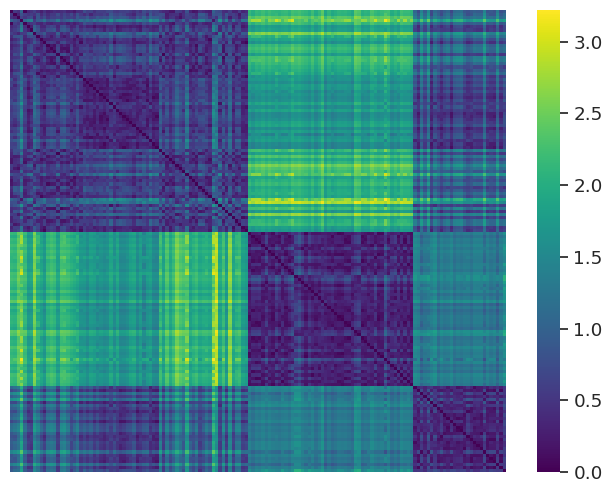

In [47]:
def nearby_cluster(dist, max_dist = 0.1, max_clusters = 4):
    # Only works for a distance matrix of the points to themselves
    # Definifng the cluster
    clusters = dict()

    # Auxiliary variables
    points_len = len(dist); points = set(range(0,points_len))

    current_cluster = 0
    
    while len(points) != 0:
        start_point = np.random.choice(list(points))
        clusters[current_cluster] = {x for x in np.where(dist[start_point]<max_dist)[0]}
        current_cluster_checked = {start_point}
        while len(current_cluster_checked) != len(clusters[current_cluster]):
            currently_checking = clusters[current_cluster].copy()
            for i in currently_checking:
                if i not in current_cluster_checked:
                    close_to_i = {x for x in np.where(dist[i]<max_dist)[0]}
                    clusters[current_cluster].update(close_to_i)
                    current_cluster_checked.add(i)
        
        points.difference_update(clusters[current_cluster])
        current_cluster += 1

    while len(clusters) > max_clusters:
        smallest_cluster = min(clusters, key=lambda k: len(clusters[k]))

        for i in clusters[smallest_cluster]:
            stop = False
            idx = 1

            while stop == False:
                stop = True

                sets_containing_value = []
                #takes the closest point to the value thats not in the same set
                closest_point = np.argsort(dist[i])[idx]
                
                for key, clust in clusters.items():
                    if closest_point in clust:
                        sets_containing_value.append(key)
                        clusters[key].add(i)

                if sets_containing_value == [smallest_cluster]:
                    stop = False
                    idx += 1
        clusters.pop(smallest_cluster)

    clusters_sorted = sorted(clusters, key=lambda k: -len(clusters[k]))
    
    clusters = {i:clusters[clusters_sorted[i]] for i in range(len(clusters_sorted))}
    return clusters

dist = distance_matrix(data, metric=lp, parameter=1)
nearby_clusters = nearby_cluster(dist, 0.05, 3)
pltf.plot_distance_matrix_by_clusters(dist, nearby_clusters)

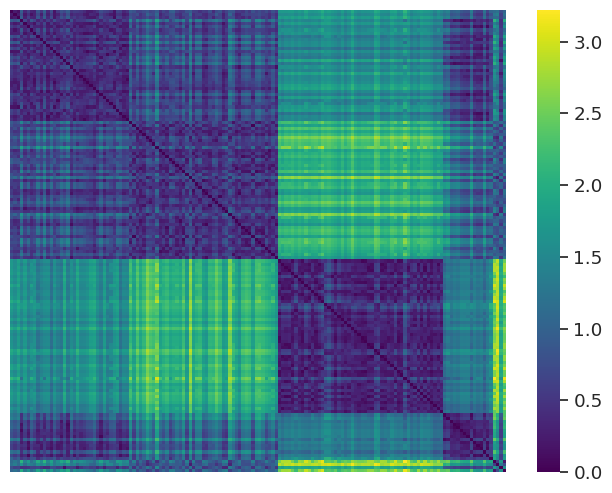

In [48]:
def boxes_cluster(dist, max_clusters = 4):
    n = len(dist)

    box = boxes(dist, max_clusters, True)

    amount_boxes = len(box)
    main_box = np.zeros((n,amount_boxes))

    for key,val in box.items():
        for point in val:
            main_box[point[0]][key] += 1

    clusters = {i:[] for i in range(max_clusters)}

    for point,appearances in enumerate(main_box):
        clusters[np.argmax(appearances)].append(point)
    
    clusters_sorted = sorted(clusters, key=lambda k: -len(clusters[k]))
    
    clusters = {i:clusters[clusters_sorted[i]] for i in range(max_clusters)}
    return clusters

box_cluster = boxes_cluster(dist, 4)
pltf.plot_distance_matrix_by_clusters(dist, box_cluster)

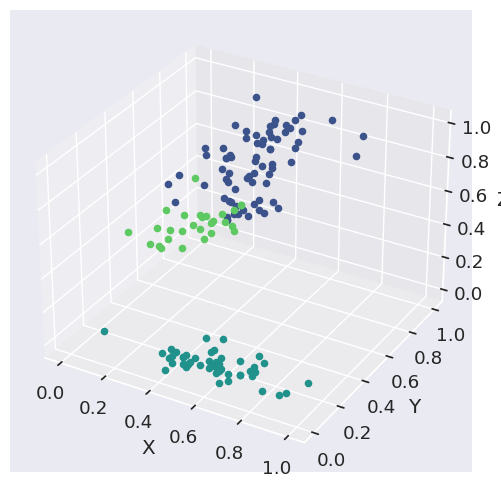

In [49]:
pltf.plot_data_by_clusters_3d(data, nearby_clusters, axis=[1,2,3])

In [42]:
def grid_cluster():
    #TODO
    pass

In [43]:
all_values = []
for vals in box_cluster.values():
    for i in vals:
        all_values.append(i)

len(all_values)

150

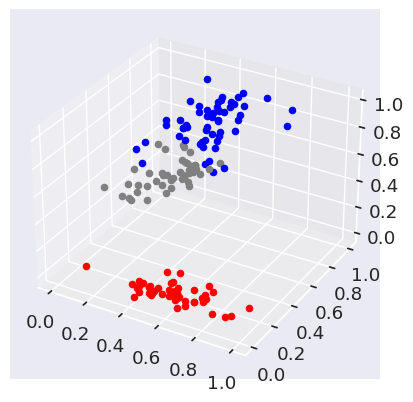

In [118]:
def plot_data_by_clusters_3d(data, clusters, palette = "viridis"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = ['blue','red','grey','green','black','pink']
    #colors = sns.color_palette(palette,20)

    for id_color,i in enumerate(clusters.values()):
        for j in i:
            ax.scatter(data[j, 1], data[j, 2], data[j, 3], c=colors[id_color], marker='o')

plot_data_by_clusters_3d(data, clusters)
            

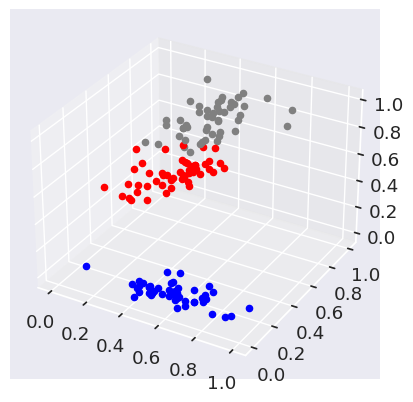

In [210]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['blue','red','grey','green','black','pink']
for id_colot,i in enumerate(clusters.values()):
    for j in i:
        ax.scatter(data[j, 1], data[j, 2], data[j, 3], c=colors[real_clusters[j]], marker='o')